![Smoke from the Thomas Fire: https://earthobservatory.nasa.gov/images/91379/smoke-and-fire-in-southern-california](banner.png)

False Color Imagery is a visual representation technique to depict data in wavelengths outside the visible spectrum, by assigning visible colors to non-visible wavelengths. This is a common practice in remote sensing to show land features that are not easily discernible to the human eye. Some remote sensing satellites carry equipment to collect data in wavelengths outside the visible spectrum, like Near-Infrared (NIR) and Shortwave Infrared (SWIR). These wavelengths can then be reassigned and visualized to create false color images of the land surface, accentuating features that would otherwise go unnoticed.

While this sounds tricky, it can be quite simple to code and visualize in programming languages, in this case Python. In this post, we will be using false color imagery to visualize the scar left behind by the Southern California Thomas Fire in December 2017, using data collected from the Landsat satellite.

The Thomas Fire was the largest wildfire in modern California history, covering an area of ~282,000 acres (1,141 sq km)[^1]. The fire started on December 4, 2017, and destroyed more than a thousand structures before it was extinguished on January 12, 2018[^2]. After burning much of the South Santa Barbara County area, heavy rainfall[^3] in January 2018 presented significant risk of mudslides, ultimately resulting in the mudflow in Montecito, California, on January 9, 2018[^4].

[^1]: https://lpdaac.usgs.gov/resources/data-action/observing-thomas-fire-using-nasa-earth-data/

[^2]: https://www.fire.ca.gov/incidents/2017/12/4/thomas-fire/

[^3]: https://www.dailynews.com/2018/01/10/rain-is-done-how-much-did-we-get/

[^4]: https://www.latimes.com/local/lanow/la-me-ln-mudslide-recovery-mainbar-20180111-story.html

[^5]: https://earthobservatory.nasa.gov/images/91379/smoke-and-fire-in-southern-california

The purpose of this post is to act as an example of how to work with shapefiles in conjunction with raster data in Python. We will do simple exploration of the `xarray.Dataset` called `landsat`, a raster image of the Santa Barbara County area that contains data for visible, infrared, and near infrared color bands (wavelengths). We will then reassign these color bands to visible colors to generate a false color image, and overlay the boundary of the Thomas Fire.

We will also calculate statistics on the land cover types affected by the fire, using land cover data from USGS. This analysis is important, as it helps identify which types of land cover were most affected by the Thomas Fire.

### Datasets

Landsat Data[^6]: The data from Landsat is a raster image of the Santa Barbara County area, retrieved from Microsoft's Planetary Computer. Planetary Computer can be accessed directly through Python, as done in this analysis.

[^6]: https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2

Fire Perimeters Data[^7]: This dataset was retrieved from Data.gov, containing shapefile geometries for every wildfire in California since 1878.

[^7]: https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436

LANDFIRE Terrestrial Ecosystems Data[^8]: This is a categorical raster of land cover types, with 30x30 meter resolution, collected by the US Geological Survey's Gap Analysis Program (GAP) in 2011. This dataset also includes a CSV file giving the names of every land cover type nationally. This data was also retrieved from Microsoft's Planetary Computer.

[^8]: https://www.sciencebase.gov/catalog/item/573cc51be4b0dae0d5e4b0c5

### Importing necessary packages:

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt

import pystac_client
import planetary_computer
from IPython.display import Image 

### Fire Data Loading and Exploration

The fire perimeter data set is huge, containing more than 20,000 fires. In this code, we have loaded and narrowed down the data set to just the 2017 Thomas Fire, and created a new shapefile for its perimeter. This way we can save some time when running the code, as we won't have to load the entire dataset, only the data we need.

In [2]:
fires = gpd.read_file("fire_perimeters/California_Fire_Perimeters_(all).shp")

print(fires.shape)
print(fires.dtypes)

(22261, 22)
OBJECTID         int64
YEAR_          float64
STATE           object
AGENCY          object
UNIT_ID         object
FIRE_NAME       object
INC_NUM         object
ALARM_DATE      object
CONT_DATE       object
CAUSE          float64
C_METHOD       float64
OBJECTIVE      float64
GIS_ACRES      float64
COMMENTS        object
COMPLEX_NA      object
IRWINID         object
FIRE_NUM        object
COMPLEX_ID      object
DECADES        float64
Shape__Are     float64
Shape__Len     float64
geometry      geometry
dtype: object


In [3]:
thomas_fire = fires[(fires['FIRE_NAME'] == 'THOMAS') & (fires['YEAR_'] == 2017)]

thomas_fire.to_file("data/thomas_fire.shp")

print(thomas_fire.shape)
print(thomas_fire.dtypes)

(1, 22)
OBJECTID         int64
YEAR_          float64
STATE           object
AGENCY          object
UNIT_ID         object
FIRE_NAME       object
INC_NUM         object
ALARM_DATE      object
CONT_DATE       object
CAUSE          float64
C_METHOD       float64
OBJECTIVE      float64
GIS_ACRES      float64
COMMENTS        object
COMPLEX_NA      object
IRWINID         object
FIRE_NUM        object
COMPLEX_ID      object
DECADES        float64
Shape__Are     float64
Shape__Len     float64
geometry      geometry
dtype: object


Now we can make our first basic visualization of the Thomas Fire perimeter.

<Axes: >

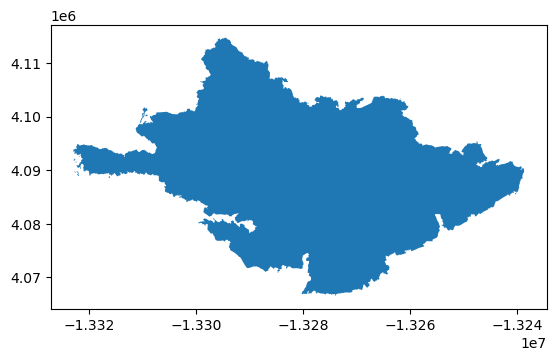

In [4]:
thomas_fire.plot()

Notice the polygon is filled in; since we only want the perimeter, we can simply use `.boundary` while plotting.

<Axes: >

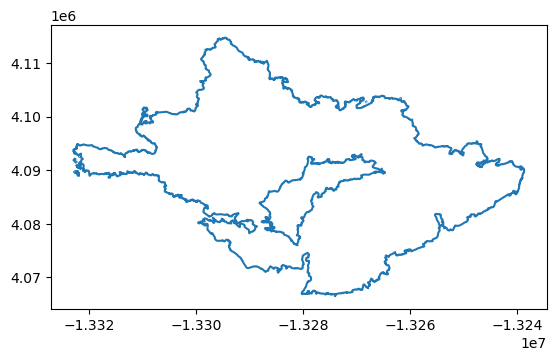

In [5]:
thomas_fire.boundary.plot()

### Landsat Data Loading and Exploration

To properly open the Landsat data, we can use a function out of the package we loaded earlier, `rioxarray`. This package is loaded as `rioxr`, and integrates the packages `rasterio`, used for loading raster data, and `xarray`, which handles labeled multidimensional arrays like time series, or in this case, multi-band imagery. We will also take a look at the head of the `xarray.Dataset` to see what it looks like.

In [6]:
fp = os.path.join("/courses/EDS220/data/hwk4_landsat_data", "landsat8-2018-01-26-sb-simplified.nc")
landsat = rioxr.open_rasterio(fp)
landsat.head()

<xarray.Dataset> Size: 1kB
Dimensions:      (band: 1, x: 5, y: 5)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 40B 1.213e+05 1.216e+05 ... 1.221e+05 1.224e+05
  * y            (y) float64 40B 3.952e+06 3.952e+06 ... 3.952e+06 3.951e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (band, y, x) float64 200B ...
    green        (band, y, x) float64 200B ...
    blue         (band, y, x) float64 200B ...
    nir08        (band, y, x) float64 200B ...
    swir22       (band, y, x) float64 200B ...

It's not the most easily digestible dataset! So we will do some basic exploration of the data, such as looking at its width, height, and bounding box. Here, the bounding box is a set of coordinates denoting 'eastings' and 'northings', or meters from the x-axis reference point in meters (the Prime Meridian) and from the y-axis reference point (the Equator). This set of two coordinates designate two opposite corners of our bounding box.

In [7]:
print('Height: ', landsat.rio.height)
print('Width: ', landsat.rio.width)
print('Bounding Box: ')
print(landsat.rio.bounds(), '\n')

Height:  731
Width:  870
Bounding Box: 
(121170.0, 3755160.0, 356070.0, 3952530.0) 



This data is multidimensional, and cannot be plotted at this point. We can drop the `band` dimension, which makes the data two dimensional for plotting. Here you can see we have removed the `band` dimension and dropped its variables.

In [8]:
landsat = landsat.squeeze().drop_vars("band")

### False Color Image

Now we can try our first visualization of the Landsat data. This is where we can arrange color bands for our visualization, but for now we will arrange them in their proper places to produce a true color image. It is important to add the argument `robust = True`, as this excludes outlying colors that create noise and distort our true color image.

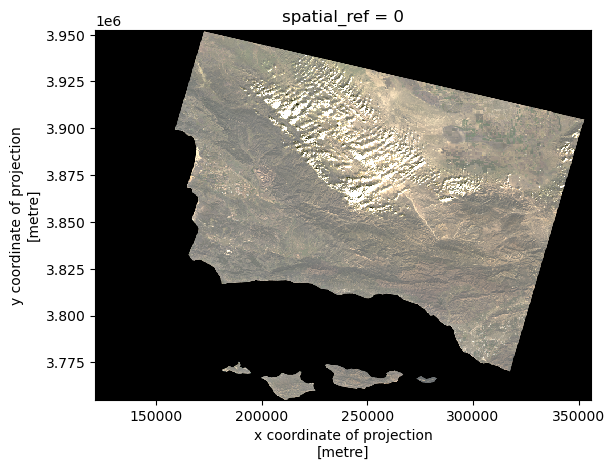

In [9]:
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust = True)

We can arrange color bands however we like! For this false color image, we are replacing the red band with shortwave infrared (SWIR), the green band with near infrared (NIR), and the blue band with red.

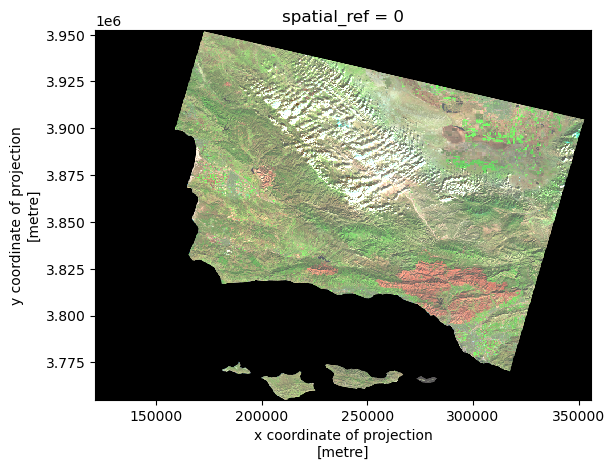

In [10]:
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)

### False Color Map

Before we make a map out of the false color image, we need to make sure that the Thomas Fire perimeter shapefile is compatible with it. We can adjust the CRS of the shapefile to match that of the Landsat data.

In [11]:
thomas_fire = thomas_fire.to_crs(landsat.rio.crs)

We will also establish an aspect ratio for out map, based on the Landsat data.

In [12]:
landsat_aspect_ratio = landsat.rio.width / landsat.rio.height

And now we can create our map!

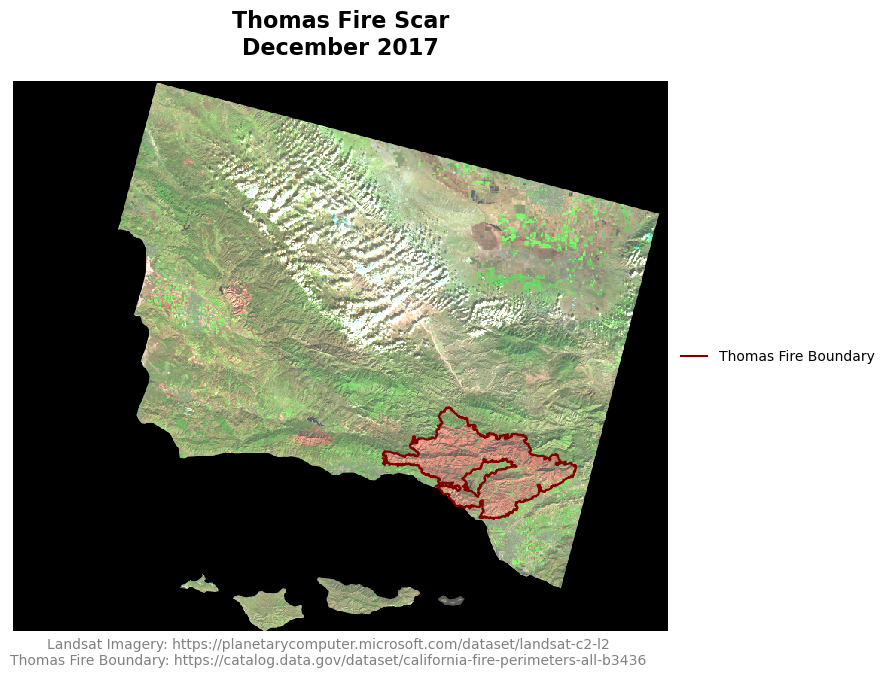

In [13]:
fig, ax = plt.subplots(figsize= (10, 6*landsat_aspect_ratio))

ax.axis('off')

landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True, 
                                                           ax=ax)

thomas_fire.boundary.plot(ax = ax, 
                          color = "maroon", 
                          label = "Thomas Fire Boundary")

ax.set_title("Thomas Fire Scar\nDecember 2017", 
             fontsize=16, 
             weight='bold', 
             pad=20)

fig.text(
    0.5, 0.06,
    "Landsat Imagery: https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2\nThomas Fire Boundary: https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436",
    ha="center", 
    va="bottom", 
    fontsize=10, 
    color="gray"
)

ax.legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=10,
    frameon=False
)


plt.show()

We have now generated a false color map of the Santa Barbara County area, using near and shortwave infrared to emphasize the fire scar left by the Thomas Fire. The boundary of the Thomas Fire has been overlayed to display the exact area affected by the fire. By replacing the red, green, and blue bands with shortwave infrared, near infrared, and red bands respectively, we can highlight burned areas, vegetation, and bodies of water. Burned areas appear in dark red and brown, as they strongly reflect shortwave infrared but absorb visible light. Living vegetation appears in bright green colors as it strongly reflects near infrared light. This method provides a clearer view of the Thomas Fire's impact on the landsacape.

### Land Cover Statistics

In order to calculate land cover statistics for the Thomas Fire, we need to load the land cover data for the extent of the fire perimeter. Here we can use a list of coordinates from the `thomas_fire` shapefile (the eastings and northings I mentioned above) to isolate just the area of the land cover raster that we need. These coordinates need to be in the Coordinate Reference System (CRS) 4326, also known as EPSG:4326 or WGS84, as this is the CRS of the land cover data.


In [14]:
thomas_fire_bbox = list(thomas_fire.to_crs('epsg:4326').total_bounds)
thomas_fire_bbox

[-119.68162520650904,
 34.279899796001956,
 -118.92518097019486,
 34.63745683414112]

Now we can import the land cover labels from the CSV file included with the GAP data. This CSV contains labels for every land cover type in the country, and so there are many that are irrelevant to this analysis, as seen when viewing the data head. Notice that there is a NULL value (0), which is used for areas outside the areas of interest (oceans).

In [15]:
labels = pd.read_csv(os.path.join('/','courses','EDS220','data', 'GAP_National_Terrestrial_Ecosystems.csv'))
labels.head()

,class_label,code
0,0,0
1,South Florida Bayhead Swamp,1
2,South Florida Cypress Dome,2
3,South Florida Dwarf Cypress Savanna,3
4,South Florida Mangrove Swamp,4


Next, we connect to the Microsoft Planetary Computer data catalog and perform a search to find our land cover data. The collection ID for the data is `gap`:

In [16]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(collections = ['gap'],
                        bbox = thomas_fire_bbox)
search

This is what we get after our search. Now have to take another step to retrieve the item from the search.

In [17]:
items = search.item_collection()
print(f"Returned {len(items)} Items")
items

Returned 1 Items


There is a single item in the search, so let's go ahead and select it and view its pre-rendered image. First we select the item, and then display the pre-rendered image:

In [18]:
item = items[0]

Image(url = item.assets['rendered_preview'].href, width = 600)

Cool!

Now we can open the `xarray.DataArray` from our search:

In [19]:
landcover = rioxr.open_rasterio(item.assets['data'].href)
landcover

<xarray.DataArray (band: 1, y: 10000, x: 10000)> Size: 200MB
[100000000 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 80kB -2.361e+06 -2.361e+06 ... -2.061e+06
  * y            (y) float64 80kB 1.762e+06 1.762e+06 ... 1.462e+06 1.462e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:        ERDAS IMAGINE
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0

At this point, our `landcover` `xarray.DataArray` is three dimensional. We'll drop the `band` dimension and its variables, just as we did before:

In [20]:
landcover = landcover.squeeze().drop_vars('band')

To ensure proper mapping, we will ensure that the Thomas Fire perimeter shapefile is the same CRS as that of the land cover data. Use `assert` to run a quick test to ensure that the code worked properly.

In [21]:
thomas_fire_match = thomas_fire.to_crs(landcover.rio.crs)
assert thomas_fire_match.crs == landcover.rio.crs

Now we can make our first plot of the land cover data, clipped to the size of the Thomas Fire perimeter shapefile, using the `total_bounds` of `thomas_fire`.

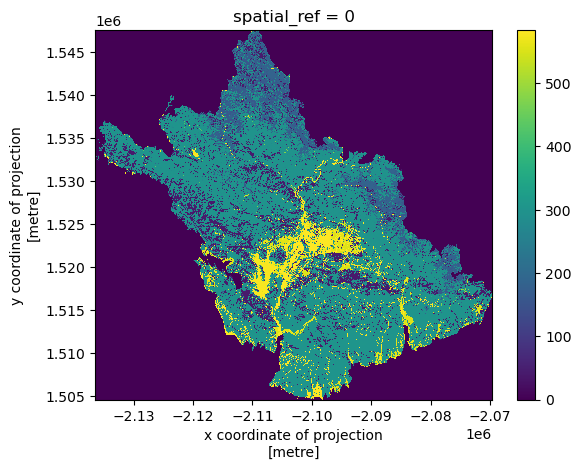

In [22]:
landcover = landcover.rio.write_nodata(0)

landcover_clip = (landcover.rio.clip_box(*thomas_fire_match.total_bounds)
              .rio.clip(thomas_fire_match.geometry))

landcover_clip.plot()

Now that the land cover types within the Thomas Fire boundary are isolated, we can begin calculating land cover type statistics. The first line finds the counts of unique values in the `landcover_clip` `xarray.DataArray`. The second line assembles these counts into a dataframe called `pix_counts`. The third line merges `pix_counts` with the `labels` dataframe we loaded earlier, as well as removes any row where the code is NULL.

In [23]:
# Count unqiue values in landcover_clip
values, counts = np.unique(landcover_clip, return_counts = True)

# Add counts to new dataframe `pix_counts`
pix_counts = pd.DataFrame({'code': values, 'count': counts})

# Merge `pix_counts` with `labels` dataframe
classes = pix_counts[pix_counts['code'] != 0].merge(labels, on='code')

Next, we find the total pixels included in the Thomas Fire perimeter, simply by adding them up. We can then find the percentage of pixels with a certain land cover type. Finally, we remove any statistically insignificant land cover types (\<1.5% coverage).

In [24]:
# Count total pixels
total_pixels = sum(classes['count'])

# Calculate percentage of pixels from each land cover type
classes['percentage'] = (classes['count'] / total_pixels) * 100

# Remove any insignificant land cover types
classes = classes[classes['percentage'] >= 1.5]

Now that we have wrangled our data, we can plot it to visualize statistics on land cover classes affected by the Thomas Fire.

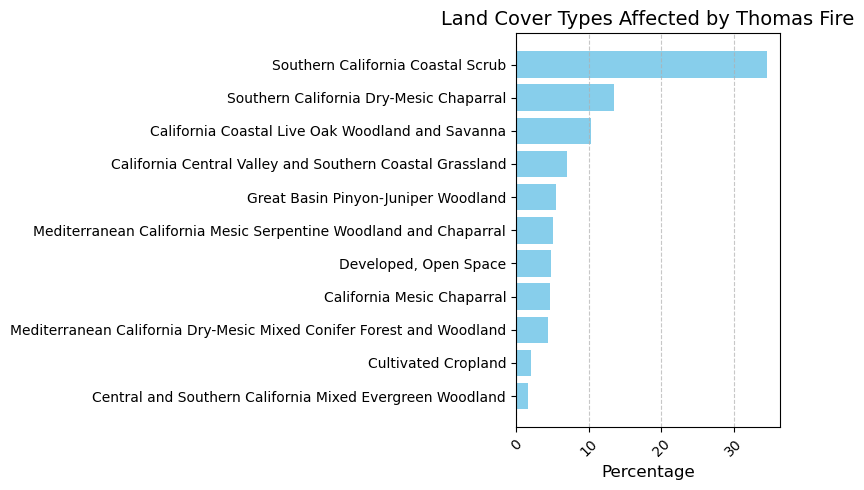

In [25]:
classes = classes.sort_values(by='percentage', ascending=True)

plt.figure(figsize=(8, 5))
plt.barh(classes['class_label'], classes['percentage'], color='skyblue')

plt.xlabel('Percentage', fontsize=12)
plt.title('Land Cover Types Affected by Thomas Fire', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()